# GLM - linear regression

https://docs.pymc.io/notebooks/GLM-linear.html

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
import pymc3 as pm
import arviz as az
import matplotlib.pyplot as plt

In [4]:
%matplotlib inline
sns.set_style('whitegrid')
print(f'PyMC3 version {pm.__version__}')

PyMC3 version 3.11.1


## Generate regression data

Create data for regression and add normally distributed noise

$$ Y = X \beta + \sigma $$
$$ Y \sim \mathrm{Normal}(X \beta,\ \sigma^2) $$

In [5]:
size = 200
true_intercept = 1
true_slope = 2

x = np.linspace(0, 1, size)
true_regression_line = true_intercept + true_slope * x

y = true_regression_line + np.random.normal(scale=0.5, size=size)
data = pd.DataFrame(dict(x=x, y=y))

Plot the regression line and the noisy data

Text(0.5, 1.0, 'generated data and underlying model')

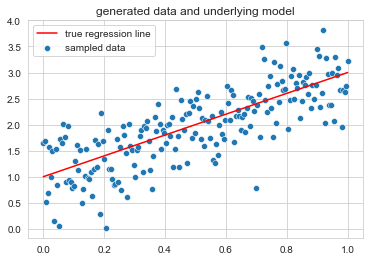

In [8]:
fig, ax = plt.subplots(1, 1)
sns.scatterplot(x=x, y=y, label='sampled data', ax=ax)
sns.lineplot(x=x, y=true_regression_line,
             label='true regression line', ax=ax,
             color='red')
ax.set_title('generated data and underlying model')

Create a Bayesian linear model and run the inference

In [12]:
with pm.Model() as model:
    # Define priors
    sigma = pm.HalfCauchy('sigma', beta=10, testval=1.)
    intercept = pm.Normal('Intercept', 0, sd=20)
    x_coeff = pm.Normal('x', 0, sd=20)

    # Define likelihood
    likelihood = pm.Normal(
        'y', mu=intercept + x_coeff * x,
        sd=sigma, observed=y)

    # Inference!
    inf_data = pm.sample(3000, tune=1000, cores=2, return_inferencedata=True)  # using NUTS sampling

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [x, Intercept, sigma]


Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 5 seconds.


Print a summary of the linear regression parameters

In [13]:
az.summary(inf_data)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.949,0.067,0.821,1.075,0.001,0.001,2896.0,2864.0,1.0
x,2.000,0.116,1.779,2.216,0.002,0.002,2826.0,3183.0,1.0
sigma,0.473,0.024,0.430,0.520,0.000,0.000,3142.0,2931.0,1.0


Specifiy the model using a string

In [15]:
with pm.Model() as model:
    # specify glm and pass in data
    # All parameters are automatically added to our model.
    pm.glm.GLM.from_formula('y ~ x', data)
    inf_data = pm.sample(3000, tune=1000, cores=2, return_inferencedata=True)  # using NUTS sampling

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, x, Intercept]


Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 5 seconds.


Print a summary of the linear regression parameters

In [16]:
az.summary(inf_data)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.952,0.065,0.829,1.071,0.001,0.001,3347.0,3387.0,1.0
x,1.997,0.113,1.786,2.210,0.002,0.001,3397.0,3513.0,1.0
sd,0.473,0.025,0.429,0.519,0.000,0.000,3644.0,3031.0,1.0


## Analyze the model

array([[<AxesSubplot:title={'center':'Intercept'}>,
        <AxesSubplot:title={'center':'Intercept'}>],
       [<AxesSubplot:title={'center':'x'}>,
        <AxesSubplot:title={'center':'x'}>],
       [<AxesSubplot:title={'center':'sd'}>,
        <AxesSubplot:title={'center':'sd'}>]], dtype=object)

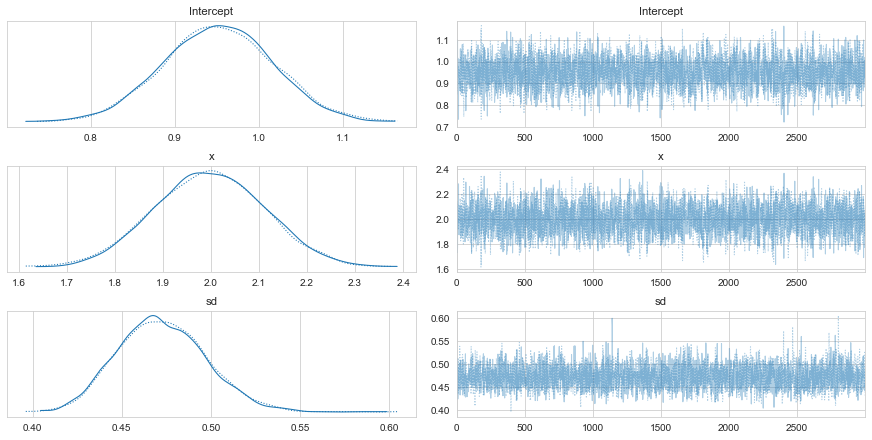

In [18]:
az.plot_trace(inf_data)

<AxesSubplot:title={'center':'Posterior predictive'}>

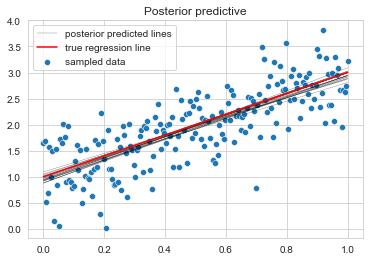

In [34]:
fig, ax = plt.subplots(1, 1)
sns.scatterplot(x=x, y=y, label='sampled data', ax=ax)
pm.plot_posterior_predictive_glm(
    inf_data, samples=20, label='posterior predicted lines')
sns.lineplot(x=x, y=true_regression_line, label='true regression line',
             color='red', ax=ax)